## 4️⃣ Create a Baseline Model
<!-- **designed by:** [datamover.ai](https://www.datamover.ai) -->

In [84]:
# Load libraries
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
from IPython.display import display
import plotly.express as px
import plotly.graph_objects as go
import sklearn as sk

# set random seed
np.random.seed(42)

pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.width", 1000)

**1. Load both the train and validation datasets**

In [38]:
import pyarrow.parquet as pq

DATA_DIR = "data"
FILENAME = "data_train_processed.parquet"

# Extract data_train_processed.parquet
train_dat = pd.read_parquet(
                                        os.path.join(DATA_DIR, FILENAME),
                                        engine='pyarrow')

# Tailor data type
train_dat = train_dat.astype(
    {
        "Price": "float64",
        "Address": "category",
        "Zip": "category",
        "Area": "float64",
        "Room": "int64",
        "Lon": "float64",
        "Lat": "float64",
        "log(Price)": "float64",
        "log(Area)": "float64",
        "log(Room)": "float64",
        "Zip_num": "category",
        "Region": "category",
        "Location": "category",
        "District": "category",
        "Delivery_area": "category",
        "AR-ratio": "float64",
        "log(AR-ratio)": "float64",
        "Euclidean_distance": "float64",
        "Haversine_distance": "float64",
        "Manhattan_distance": "float64"
        }
)

train_dat.rename(columns={'log(Price)':'log_price',
                          'log(Area)': 'log_area',
                          'AR-ratio': 'ar_ratio',
                          'log(AR-ratio)': 'log_ar_ratio',
                          'log(Room)': 'log_room'}, inplace=True)


In [39]:
DATA_DIR = "data"
FILENAME = "data_val_processed.parquet"

# Extract data_val_processed.parquet
val_dat = pd.read_parquet(
                                        os.path.join(DATA_DIR, FILENAME),
                                        engine='pyarrow')

# Tailor data type
val_dat = val_dat.astype(
    {
        "Price": "float64",
        "Address": "category",
        "Zip": "category",
        "Area": "float64",
        "Room": "int64",
        "Lon": "float64",
        "Lat": "float64",
        "log(Price)": "float64",
        "log(Area)": "float64",
        "log(Room)": "float64",
        "Zip_num": "category",
        "Region": "category",
        "Location": "category",
        "District": "category",
        "Delivery_area": "category",
        "AR-ratio": "float64",
        "log(AR-ratio)": "float64",
        "Euclidean_distance": "float64",
        "Haversine_distance": "float64",
        "Manhattan_distance": "float64"
        }
)

val_dat.rename(columns={'log(Price)':'log_price',
                          'log(Area)': 'log_area',
                          'AR-ratio': 'ar_ratio',
                          'log(AR-ratio)': 'log_ar_ratio',
                          'log(Room)': 'log_room'}, inplace=True)


In [40]:
#display size of train and validation data respectively
print("train_dat:",train_dat.shape)
print("val_dat:",val_dat.shape)

train_dat: (552, 20)
val_dat: (184, 20)


**2. Start to fit a simple model, i.e., [linear regression](https://www.statsmodels.org/stable/regression.html) for regression problems and [logistic regression](https://www.statsmodels.org/stable/discretemod.html) for classification problems.**
- use the [stastmodels](https://www.statsmodels.org/stable/index.html) API in this phase as they provide out-of-the-box comprehensive summary statistics.
- try to comply as much as possible with the model assumptions [[link ols](https://statisticsbyjim.com/regression/ols-linear-regression-assumptions/), [link logit](https://www.statology.org/assumptions-of-logistic-regression/)].

💁‍♂️ Apply one-hot encoding before fitting a model if you include categorial features in your model.

Let's start to fit a model with all the features that have shown a statistically significant relationship with the target. Consider the log-transformed features when available, as they resemble a more Gaussian distribution than the original one.

In [41]:
# Given Region, location were feature engineered from Zip variable
# I first checked whether these two variables showes any overlap
df= train_dat[['Region', 'Location']]
df.groupby(['Region']).count().sort_values(by='Location', ascending=False)

#results indicated that region = 1 were captured by only 1 unique location, 
# indicating we can just use location to conceptually capture region information(i.e., urban vs outskirts)
df.groupby(['Region']).agg({'Location': 'nunique'}).sort_values(by='Location', ascending=False)

# when testing VIF, removing region improved the VIF score, thus I decided to remove region variable from my model

,Location
Region,
0,8
1,1


- We conclude that conceptually Region is captured by Location, and including this variable will not increase model performance 

In [42]:
# Final model selection 
import statsmodels.formula.api as smf

# Model included interaction term between log_area and location showed improved performance, 
# however, it also makes the model more complex, thus I decided to remove it from the final model
# lm = smf.ols("log_price ~ log_area + Location +log_area:Location -1", data= train_dat)

# final model removing intercept
lm = smf.ols("log_price ~ log_area + Location + Manhattan_distance -1", data= train_dat) 
model = lm.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     377.5
Date:                Mon, 28 Aug 2023   Prob (F-statistic):          1.47e-236
Time:                        09:58:47   Log-Likelihood:                 131.04
No. Observations:                 552   AIC:                            -240.1
Df Residuals:                     541   BIC:                            -192.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Location[0]            8.8232      0

Model diagnostic: 

(1) OLS assumption: The error term has a population mean of zero


In [43]:
round(np.mean(model.resid, axis=0),2)

0.0

(2) OLS assumption: The regression model is linear in the coefficients

- The [Ramsey RESET Test](https://cran.r-project.org/web/packages/lmtest/lmtest.pdf) is used to determine whether any nonlinear combination of the explanatory variables can help explain the dependent variable ([Documentation](https://www.statsmodels.org/devel/generated/statsmodels.stats.diagnostic.linear_reset.html)).

In [44]:
# Model diagnostics: 
# Linearity test (Ramsey RESET Test)
import statsmodels.stats as ss
linearity = ss.diagnostic.linear_reset(model, power=2, test_type='fitted', \
                                          use_f=True, cov_type='HC3', cov_kwargs=None)

print(f"F-value: {linearity.statistic:.2f}")
print(f"p-value: {linearity.pvalue:.3f}")

alpha=0.05
if linearity.pvalue <= alpha:
    print(f"The result suggests that there is a non-linear relationship between target and feature variables.")
else: 
     print(f"The result suggests that there is a linear relationship between target and feature variables.")


F-value: 25.43
p-value: 0.000
The result suggests that there is a non-linear relationship between target and feature variables.


/opt/anaconda3/envs/Anacoda/lib/python3.10/site-packages/statsmodels/stats/diagnostic.py:1065: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



- Below plotted Residuals vs fitted plot also indicated the presence of non-linear relationship between features and target variables, as the red line strongly deviates from the horizontal line, as well as the presence of heteroskedasticity.

Text(0, 0.5, 'Residuals')

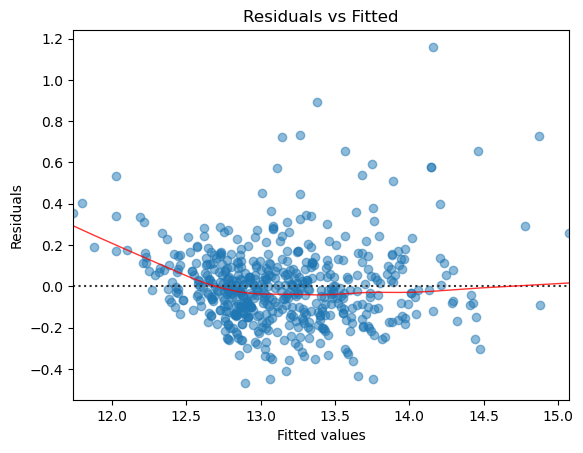

In [45]:
# compute fitted values
model_fitted_y = model.fittedvalues

# Plot residual vs. fitted values
plot = sns.residplot(x=model_fitted_y, y='log_price', data=train_dat, lowess=True, 
                     scatter_kws={'alpha': 0.5}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot.set_title('Residuals vs Fitted')
plot.set_xlabel('Fitted values')
plot.set_ylabel('Residuals')

Next, we test for OLS efficiency property

(3) OLS assumption: The error term has a constant variance (no heteroscedasticity)

- The [Breusch-Pagan Test](https://www.geeksforgeeks.org/how-to-perform-a-breusch-pagan-test-in-python/) is used to determine whether or not heteroscedasticity is present in a regression model ([Documentation](https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.het_breuschpagan.html)).

In [46]:
import statsmodels.stats as ss
x = train_dat[['log_area', 'Location']]
x = x.assign(**{'constant': 1})
breuschpagan = ss.diagnostic.het_breuschpagan(model.resid, x, robust=True)
     
print(f"F-value: {breuschpagan[2]:.2f}")
print(f"p-value: {breuschpagan[3]:.3f}")

alpha=0.05
if breuschpagan[3]<= alpha:
    print(f"The result suggests that the error term is heteroskedastic.")
else: 
     print(f"The result suggests that the error term is homoskedastic.")


F-value: 12.92
p-value: 0.000
The result suggests that the error term is heteroskedastic.


(4) OLS assumption: Observations of the error term are uncorrelated with each other

- The [Breusch-Godfrey Test](https://www.statology.org/breusch-godfrey-test-python/) is used to test for autocorrelation in the errors in a regression model ([Documentation](https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.acorr_breusch_godfrey.html)).

In [47]:
lags = 1
acorr = ss.diagnostic.acorr_breusch_godfrey(model, nlags=lags)

print(f"F-value: {acorr[2]:.2f}")
print(f"p-value: {acorr[3]:.3f}")


alpha=0.05
if acorr[3]<= alpha:
    print(f"The result suggests that the error term has auto-correlation of order {lags}.")
else: 
     print(f"The result suggests that the error term has no auto-correlation of order {lags}.")

F-value: 0.55
p-value: 0.461
The result suggests that the error term has no auto-correlation of order 1.


Based on the above two tests, we need to correct for heteroscedasticity.

- The NeweyWest estimator produces standard errors robust to both heteroscedasticity and autocorrelation (cov_type='HAC' in model.fit())
- The White estimator produces standard errors robust to heteroscedasticity only (cov_type='HC3' in model.fit())



In [48]:
# Using the Newey West estimator 
model_nw = lm.fit(cov_type='HAC',cov_kwds={'maxlags':1}, use_t= True)

#statsmodel does not offer up-to-date solution for Newey West robust standard errors
#different specification of can lead to different results (needs to compare with R output at somepoint)
# model_nw = model.get_robustcov_results(cov_type='HAC',maxlags=1) 

print(model_nw.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 28 Aug 2023   Prob (F-statistic):                nan
Time:                        09:58:47   Log-Likelihood:                 131.04
No. Observations:                 552   AIC:                            -240.1
Df Residuals:                     541   BIC:                            -192.6
Df Model:                          10                                         
Covariance Type:                  HAC                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Location[0]            8.8232      0

In [49]:
# Using the White estimator 
model_w = lm.fit(cov_type='HC3', use_t= True)
# model_w = model.get_robustcov_results(cov_type='HC3')

print(model_w.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 28 Aug 2023   Prob (F-statistic):                nan
Time:                        09:58:47   Log-Likelihood:                 131.04
No. Observations:                 552   AIC:                            -240.1
Df Residuals:                     541   BIC:                            -192.6
Df Model:                          10                                         
Covariance Type:                  HC3                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Location[0]            8.8232      0

(5) OLS assumption: The error term is normally distributed


- The [Jarque-Bera Test](https://www.statisticshowto.com/jarque-bera-test/) is used to test whether the sample data has the skewness and kurtosis matching a normal distribution([Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.jarque_bera.html)).

In [50]:
from scipy import stats

normality = stats.jarque_bera(model_nw.resid)

print(f"Chi-squared statistic: {normality.statistic:.2f}")
print(f"p-value: {normality.pvalue:.3f}")

alpha=0.05
if normality.pvalue <= alpha:
    print(f"The result suggests that the error term is not normally distributed.")
else: 
     print(f"The result suggests that the error term is not normally distributed.")


Chi-squared statistic: 574.17
p-value: 0.000
The result suggests that the error term is not normally distributed.


In [51]:
# non-parametric test on normality also showed that the error term is not normally distributed
Omnibus_test = sm.stats.omni_normtest(model_nw.resid)

print(f"Chi-squared statistic: {Omnibus_test.statistic:.2f}")
print(f"p-value: {Omnibus_test.pvalue:.3f}")


alpha=0.05
if Omnibus_test.pvalue <= alpha:
    print(f"The result suggests that the error term is not normally distributed.")
else: 
     print(f"The result suggests that the error term is not normally distributed.")


Chi-squared statistic: 154.25
p-value: 0.000
The result suggests that the error term is not normally distributed.


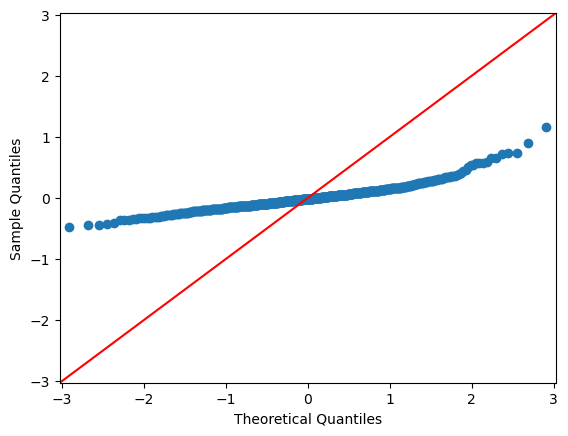

In [52]:
import pylab as py
sm.qqplot(model_nw.resid, line ='45')
py.show()

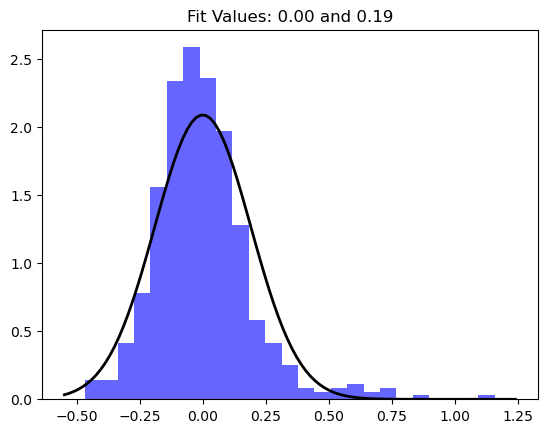

In [53]:
from scipy.stats import norm
# Fit a normal distribution to the data:
# mean and standard deviation
mu, std = norm.fit(model_nw.resid) 
  
# Plot the histogram.
plt.hist(model_nw.resid, bins=25, density=True, alpha=0.6, color='b')
  
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
  
plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)
  
plt.show()

- From the above normality test result and the visualisation (qq plot and histgram), we can deduce that the errors are not normally distributed because they exhibit high kurtosis and positive skewness. 

- We can derive robust inferences using bootstrapping (i.e., the empirical distribution of beta)

In [54]:
# creating dummy variables for location in order to perform bootstrapping
dummy = pd.get_dummies(train_dat['Location'], prefix='Location',drop_first=False).astype('int64')
train_dat_dummy = pd.concat([train_dat,dummy], axis=1)
train_dat_dummy=pd.DataFrame(train_dat_dummy)
boots_res_dat = train_dat_dummy[["log_price","log_area", "Manhattan_distance", "Location_0", "Location_1", "Location_2", "Location_3", "Location_5", "Location_6", "Location_7", "Location_8", "Location_9"]]

In [55]:
# creating empty list so the results of each coefficeints can be appended
betas_summary = {'log_area_beta':[],
                 'Manhattan_distance_beta':[],
                 'Location_0_beta':[],
                 'Location_1_beta':[],
                 'Location_2_beta':[],
                 'Location_3_beta':[],
                 'Location_5_beta':[],
                 'Location_6_beta':[],
                 'Location_7_beta':[],
                 'Location_8_beta':[],
                 'Location_9_beta':[]}

# creating 999 bootstrap samples
bs = range(1,1000,1) 

for i in bs:
    # Creating a bootstrap sample with replacement
    bootsample = boots_res_dat.sample(n=boots_res_dat.shape[0], replace=True)
    # Fitting the model with the bootstrap sample
    lm = smf.ols("log_price  ~ log_area + Manhattan_distance + Location_0 + Location_1 + Location_2 + Location_3 + Location_5 + Location_6 + Location_7 + Location_8 + Location_9 -1", data= bootsample)
    model = lm.fit()
    #appending the results of each coefficient
    betas_summary['log_area_beta'].append(model.params['log_area'])
    betas_summary['Manhattan_distance_beta'].append(model.params['Manhattan_distance'])
    betas_summary['Location_0_beta'].append(model.params['Location_0'])
    betas_summary['Location_1_beta'].append(model.params['Location_1'])
    betas_summary['Location_2_beta'].append(model.params['Location_2'])
    betas_summary['Location_3_beta'].append(model.params['Location_3'])
    betas_summary['Location_5_beta'].append(model.params['Location_5'])
    betas_summary['Location_6_beta'].append(model.params['Location_6'])
    betas_summary['Location_7_beta'].append(model.params['Location_7'])
    betas_summary['Location_8_beta'].append(model.params['Location_8'])
    betas_summary['Location_9_beta'].append(model.params['Location_9'])


In [56]:
#To compare the bootstrapped coefficients with the original coefficients
# I first computed the mean and 95% confidence interval of the bootstrapped coefficients
boots_coeff = pd.DataFrame(betas_summary)
mean_coeff = boots_coeff.mean(axis=0)
quantile_coeff = boots_coeff.quantile([0.025, 0.975])


betas_coeff_summary = {'mean': mean_coeff,
                      '2.5quantile':quantile_coeff.iloc[0,:],
                      '97.5quantile':quantile_coeff.iloc[1,:]}

betas_coeff_summary = pd.DataFrame(betas_coeff_summary).reset_index()
betas_coeff_summary.set_index('index', inplace=True)
betas_coeff_summary #results are quite similar to the model coefficients and confidence interval

,mean,2.5quantile,97.5quantile
index,,,
log_area_beta,0.93,0.89,0.98
Manhattan_distance_beta,-2.33,-3.60,-1.23
Location_0_beta,8.84,8.61,9.06
Location_1_beta,9.33,9.15,9.52
Location_2_beta,8.96,8.74,9.17
Location_3_beta,9.00,8.78,9.21
Location_5_beta,9.29,9.10,9.46
Location_6_beta,8.92,8.71,9.13
Location_7_beta,9.39,9.19,9.58


- Results from bootrap indicate that our inferences are robust to non-normality of errors 

**3. Measure the [Variance Inflation Factor (VIF)](https://www.investopedia.com/terms/v/variance-inflation-factor.asp) for each model fit. If the VIF of each feature is below 5, continue to step 4; otherwise, go to step 2 before removing highly correlated features.**

In [57]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

x = train_dat[['log_area', 'Location','Manhattan_distance']] #when checking VIF, preferrably to use categorical variables rather than dummy variables

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = x.columns
vif_data["VIF"] = [variance_inflation_factor(x.values, i)
                          for i in range(len(x.columns))]

vif_data

,feature,VIF
0,log_area,5.59
1,Location,3.27
2,Manhattan_distance,3.31


- Inclusion of Manhattan Distance inflated VIF results, however, consider conceptually it brings new information to the model, I included this variable. 

**4. Assess the feature’s importance and provide an interpretation of the overall model**

⚠️ Make sure to standardise the features before assessing their impact on the model output. 


- See [link1](https://www.statalist.org/forums/forum/general-stata-discussion/general/1418218-does-it-make-sense-to-do-both-standardization-and-logarithm-transformation) and [link2](https://www.statalist.org/forums/forum/general-stata-discussion/general/1418218-does-it-make-sense-to-do-both-standardization-and-logarithm-transformation) for justification to standardaise original values (over log transformed ones)

- However, with the aim of comparing the magnititude of model coefficents, the log transformed and non-transformed  features similar patterns. I thus used the former to present feature importance (in order to be more consistent with variable selection of the model in train set)  



In [58]:
train_dat.describe()

,Price,Area,Room,Lon,Lat,log_price,log_area,log_room,ar_ratio,log_ar_ratio,Euclidean_distance,Haversine_distance,Manhattan_distance
count,552.00,552.00,552.00,552.00,552.00,552.00,552.00,552.00,552.00,552.00,552.00,552.00,552.00
mean,611200.74,94.70,3.53,4.89,52.36,13.14,4.43,1.18,27.16,3.25,3.44,3.89,0.06
std,516752.98,55.15,1.52,0.05,0.02,0.54,0.48,0.40,13.18,0.30,2.13,2.44,0.04
min,175000.00,21.00,1.00,4.66,52.29,12.07,3.04,0.00,13.50,2.60,0.07,0.08,0.00
25%,350000.00,60.00,3.00,4.85,52.35,12.77,4.09,1.10,20.94,3.04,1.93,2.15,0.03
50%,462000.00,82.00,3.00,4.89,52.36,13.04,4.41,1.10,25.00,3.22,2.99,3.33,0.05
75%,695000.00,111.00,4.00,4.92,52.38,13.45,4.71,1.39,30.52,3.42,4.60,5.05,0.08
max,5950000.00,497.00,14.00,5.03,52.42,15.60,6.21,2.64,258.00,5.55,13.50,16.15,0.24


In [59]:
from sklearn import preprocessing
# from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler


#select variables from -- since we are standardising the data, I used raw variables prior to log transformation 
res_stan = train_dat[['log_price','log_area','Location','Manhattan_distance']]

# Transform categorical variable (Location) into dummy variables
label_binarizer = LabelBinarizer()
label_binarizer_output = label_binarizer.fit_transform(res_stan.select_dtypes('category'))

result_df = pd.DataFrame(label_binarizer_output,
                         columns = label_binarizer.classes_)
# Add prefix to the column names
prefix = 'Location_'
result_df = result_df.add_prefix(prefix)

#standardise the numeric features
scaler= StandardScaler(with_mean=True, with_std=True)
scale = scaler.fit_transform(res_stan.select_dtypes('float64')) 

scale_df = pd.DataFrame(scale,
                         columns = ['log_price_standard','log_area_standard','Manhattan_distance_standard'])

#combine the standardised numeric features and dummy variables 
res = pd.concat([scale_df,result_df], axis=1)

# Display standardised dataset for regression model
display(res.head(2))


,log_price_standard,log_area_standard,Manhattan_distance_standard,Location_0,Location_1,Location_2,Location_3,Location_5,Location_6,Location_7,Location_8,Location_9
0,0.40,-0.07,-0.73,0,0,0,0,0,0,1,0,0
1,-0.45,-0.66,-0.60,0,0,0,0,1,0,0,0,0


In [60]:
# standardise the trainset indeed improved VIF score (resolving multicollinearity issue showed above)
from statsmodels.stats.outliers_influence import variance_inflation_factor

x = res[['log_area_standard','Manhattan_distance_standard','Location_0','Location_1','Location_2','Location_3','Location_5','Location_6','Location_7','Location_8','Location_9']]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = x.columns
vif_data["VIF"] = [variance_inflation_factor(x.values, i)
                          for i in range(len(x.columns))]

vif_data

,feature,VIF
0,log_area_standard,1.13
1,Manhattan_distance_standard,3.91
2,Location_0,2.24
3,Location_1,1.74
4,Location_2,1.05
5,Location_3,1.05
6,Location_5,1.14
7,Location_6,1.50
8,Location_7,1.15
9,Location_8,1.07


In [61]:
predictor = ["log_area_standard", "Manhattan_distance_standard", "Location_0", "Location_1", "Location_2", "Location_3", "Location_5", "Location_6", "Location_7", "Location_8", "Location_9"]
target = "log_price_standard"

X = res[predictor]
Y = res[target]

In [62]:
lm = smf.ols("log_price_standard  ~ log_area_standard + Manhattan_distance_standard +\
Location_0 + Location_1 + Location_2 + Location_3 + Location_5 + Location_6 + Location_7 +  Location_8 + Location_9 -1", data= res)
model_standarised = lm.fit(cov_type='HAC',cov_kwds={'maxlags':1}, use_t= True)#.get_robustcov_results(cov_type='HAC',maxlags=1)

print(model_standarised.summary())

                            OLS Regression Results                            
Dep. Variable:     log_price_standard   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 28 Aug 2023   Prob (F-statistic):                nan
Time:                        09:58:59   Log-Likelihood:                -210.08
No. Observations:                 552   AIC:                             442.2
Df Residuals:                     541   BIC:                             489.6
Df Model:                          10                                         
Covariance Type:                  HAC                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
log_area_standard 

                             importance
feature                                
log_area_standard                  0.83
Location_7                         0.42
Location_1                         0.33
Location_5                         0.24
Location_9                         0.21
Location_8                        -0.09
Manhattan_distance_standard       -0.17
Location_3                        -0.29
Location_2                        -0.36
Location_6                        -0.44
Location_0                        -0.61


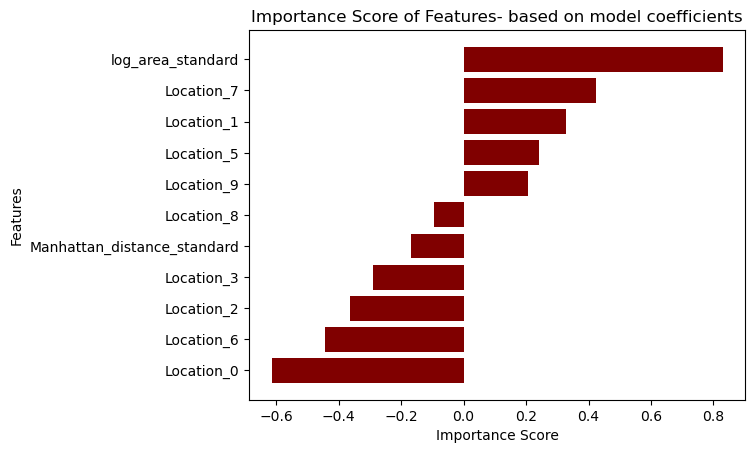

In [63]:
# In predictive modelling, it is recommendable to use model coefficients to determine the importance of each feature
# Below section implemented this approach

from matplotlib import pyplot

# get importance
importance = model_standarised.params
feature= X.columns.tolist()
# using dictionary comprehension to convert lists to dictionary
label = {feature[i]: importance[i] for i in range(len(feature))}
label= pd.DataFrame.from_dict(label,orient='index').reset_index().rename(columns={'index':'feature', 0:'importance'})
label = label.sort_values(by='importance', ascending=True).set_index('feature')

print(label.sort_values(by='importance', ascending=False))


# creating the bar plot
plt.barh(label.index, label['importance'], color='maroon')
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Importance Score of Features- based on model coefficients")
plt.show()

**5. Assess the model quality via** 
- [diagnostic plots](https://data.library.virginia.edu/diagnostic-plots/) if you are dealing with a regression problem.
- [performance metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) defined in 0️⃣ b) Define Analytical Needs;


Text(0, 0.5, 'Residuals')

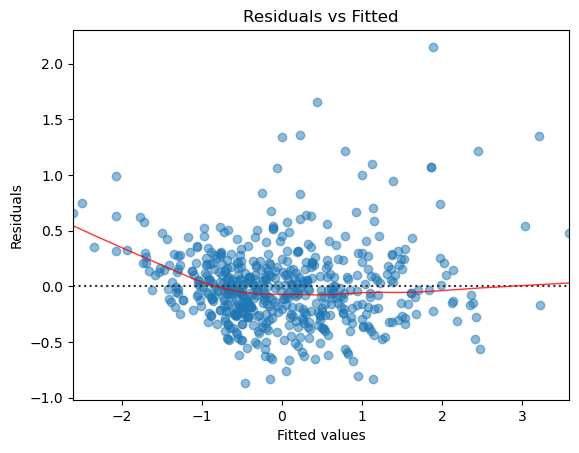

In [64]:
# compute fitted values
model_fitted_y = model_standarised.fittedvalues

#  Plot residual vs. fitted values
plot = sns.residplot(x=model_fitted_y, y='log_price_standard', data=res, lowess=True, 
                     scatter_kws={'alpha': 0.5}, 
                     line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot.set_title('Residuals vs Fitted')
plot.set_xlabel('Fitted values')
plot.set_ylabel('Residuals')

In [65]:
print(f"R square: {model_standarised.rsquared_adj:.3f}")

R square: 0.872


**6. Keep track of the model performance and annotate your baseline model. As a final check, you can:**
- show the scatter plot between the [predicted values versus the actual](https://statisticsglobe.com/plot-predicted-vs-actual-values-in-r) for both training and validation set for a regression problem;
- the [decision boundary](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html) in the case of a classification problem. 

💁‍♀️ Aim to retrieve a model with the least amount of predictors while achieving a desired level of performance.


In [106]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,r2_score,max_error

df = train_dat_dummy.copy()
X = df[["log_area", "Manhattan_distance", "Location_0", "Location_1", "Location_2", "Location_3", "Location_5", "Location_6", "Location_7", "Location_8", "Location_9"]]
y = df["log_price"]


model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = model.predict(X)
r2_t = round(r2_score(y, y_pred),3)
mae_t = round(mean_absolute_error(y, y_pred),3)
rmse_t = round(mean_squared_error(y, y_pred, squared = False),3)
max_error_t = round(max_error(y, y_pred),3)


print(model)
# print("\tExplained variance:", round(explained_variance_score(y, y_pred),3))
print(f"\tR2 score: {r2_t}" )
print(f"\tMean absolute error(MAE):{mae_t}")
print(f"\tRoot Mean Square Error(RMSE): {rmse_t}")
print(f"\tMax Error: {max_error_t}")

# Plot the predicted vs actual values
fig = px.scatter(x=y, y=y_pred, labels={'x': 'Observed values', 'y': 'Predicted values'})
fig.add_shape(
    type="line", line=dict(dash='dash'),
    x0=y.min(), y0=y.min(),
    x1=y.max(), y1=y.max()
)
fig.show()

LinearRegression(fit_intercept=False)
	R2 score: 0.875
	Mean absolute error(MAE):0.138
	Root Mean Square Error(RMSE): 0.191
	Max Error: 1.16


**7. Pick the baseline model and newly train the corresponding model, this time using the [sklearn API](https://scikit-learn.org/stable/). Carry out basic checks to assess the correctness of the model.**


In [67]:
# To evaluate estimator performance, I used cross validation approach

# First, combining both train and validation dataset into one dataset:  
combined_dat = pd.concat([train_dat,val_dat], axis=0)

# Second, creating dummy variables for location variable 
# in statsmodel we can rely on removing intercept to have coefficients for all dummy variables
# in sklearn, we need to first create dummy variables to keep the same model specification 
dummy = pd.get_dummies(combined_dat['Location'], prefix='Location',drop_first=False).astype('int64')
combined_dat_wd = pd.concat([combined_dat,dummy], axis=1)

In [68]:
# Next, we first specify the variables will be used in the model for both features and target 
X = combined_dat_wd[["log_area", "Manhattan_distance", "Location_0", "Location_1", "Location_2", "Location_3", "Location_5", "Location_6", "Location_7", "Location_8", "Location_9"]]
y= combined_dat_wd['log_price']

In [76]:
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_error, r2_score,max_error

kf = KFold(n_splits = 10)
rkf = RepeatedKFold(n_splits=10, n_repeats=5000, random_state = 42)

r2_cv = [] 
mae_cv = []
rmse_cv = []
max_error_cv = []

# for i, (train_index, val_index) in enumerate(kf.split(X)):
for i, (train_index, val_index) in enumerate(rkf.split(X)):
    reg = LinearRegression(fit_intercept=False).fit(X.iloc[train_index], y.iloc[train_index])
    ypred = reg.predict(X.iloc[val_index])
    r2_cv.append(r2_score(y.iloc[val_index], ypred))
    mae_cv.append(mean_absolute_error(y.iloc[val_index], ypred))
    rmse_cv.append(mean_squared_error(y.iloc[val_index], ypred, squared = False))
    max_error_cv.append(max_error(y.iloc[val_index], ypred))
    
r2_score_cv = round(sum(r2_cv)/len(r2_cv), 3) 
MAE_cv = round(sum(mae_cv)/len(mae_cv), 3)
RMSE_cv = round(sum(rmse_cv)/len(rmse_cv), 3)
max_error_cv = round(sum(max_error_cv)/len(max_error_cv), 3)
  
print(f"r2_score: {r2_score_cv}")
print(f"MAE: {MAE_cv}")
print(f"RMSE: {RMSE_cv}")
print(f"Max Error: {max_error_cv}")

r2_score: 0.862
MAE: 0.142
RMSE: 0.194
Max Error: 0.687


In [77]:
Model_performance = [{'model': 'model_trained' ,'R2_score': r2_t, 'MAE': mae_t, 'RMSE': rmse_t,'Max Error': max_error_t}, 
                    {'model': 'model_cv', 'R2_score': r2_score_cv, 'MAE': MAE_cv, 'RMSE': RMSE_cv,'Max Error': max_error_cv}
                     ]

Model_performance = pd.DataFrame(Model_performance)
Model_performance.set_index('model').transpose()


model,model_trained,model_cv
R2_score,0.88,0.86
MAE,0.14,0.14
RMSE,0.19,0.19
Max Error,1.16,0.69


**8. Save the model as a [pickle](https://scikit-learn.org/stable/model_persistence.html) file together with its model performance and relevant metadata.** 

🚨This model is not production ready.


In [90]:
# First, save the dataset prepared for modelling
import csv
import os  

DATA_DIR = "data"
os.makedirs('DATA_DIR', exist_ok=True)  
train_dat_dummy.to_csv(os.path.join(DATA_DIR, 'train_dat_with_dummy.csv'), header = True, index=False)
combined_dat_wd.to_csv(os.path.join(DATA_DIR, 'train_val_with_dummy.csv'), header = True, index=False)
Model_performance.to_csv(os.path.join(DATA_DIR, 'Baseline_model_performance.csv'), header = True, index=False)


In [104]:
# Next, save model into pickle object 
import pickle # library for save and load regression models

X = ["log_area", "Manhattan_distance", "Location_0", "Location_1", "Location_2", "Location_3", "Location_5", "Location_6", "Location_7", "Location_8", "Location_9"]
y = ["log_price"]

model = LinearRegression(fit_intercept=False)
#Fitting model with training data
model.fit(train_dat_dummy[X], train_dat_dummy[y])

# save the model to disk
filename = 'finalized_model.sav'
pickle.dump([model,X,y,Model_performance,train_dat_dummy,combined_dat_wd ], open(filename, 'wb'))

In [105]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model[: -2]

[LinearRegression(fit_intercept=False),
 ['log_area',
  'Manhattan_distance',
  'Location_0',
  'Location_1',
  'Location_2',
  'Location_3',
  'Location_5',
  'Location_6',
  'Location_7',
  'Location_8',
  'Location_9'],
 ['log_price'],
            model  R2_score  MAE  RMSE  Max Error
 0  model_trained      0.88 0.14  0.19       1.16
 1       model_cv      0.86 0.14  0.19       0.69]